## Room Occupancy detection data (IoT sensor)

1.  Gerçek IoT verisi üzerinde gözetimli öğrenme algoritmalarını test edeceksin. Amaç, verideki değişkenleri analiz ederek odada insan varlığını (occupancy) tespit etmek.

2. Veriye ilişkin detaylı bilgi için "Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models" makalesini okuyabilirsiniz.

3. Üç adet veri seti mevcut: Veriseti1: Kapılar kapalıyken alınmış ölçümler. Veriseti2: Kapılar kapalıyken alınmış başka bir veri seti. Veriseti3: Kapılar açıkken alınmış ölçümler.

4. Hedef parametreniz Occupancy. İnsan varlığı 1, insan yokluğu 0 değerlerine karşılık geliyor.

**Veriseti1:** Kapılar kapalıyken alınmış ölçümler. Gate  = 0   
**Veriseti2:** Kapılar kapalıyken alınmış başka bir veri seti. Gate  = 0     
**Veriseti3:** Kapılar açıkken alınmış ölçümler. Gate  = 1

**Temperature** = Sıcaklık   
**Humidity** = Nem  
**Light** = Işık  
**CO2** = Oksijen  
**HumidityRatio** = Nem Oranı  
**Occupancy** = İnsan varlığı

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Proje kullanılan fonksiyonlar:   

In [98]:
# df hakkında genel bilgi :  
#veri seti hakkında genel bir bilgi almak için temek pandas fonksiyonlarını bir fonk. haline getirerek, 
#veri setini ilk bakışta analiz etmek için yazılıan fonksiyon. Bizden girdi olarak incelenmek istenen veri setini, ve head değerini istemkte.
def check_df(dataframe,head = 5):
    print(" Shape ".center(60, '#'))
    print('Observations -------> {}'.format(df.shape[0]))
    print('Features     -------> {}'.format(df.shape[1]))
    print(" Types ".center(60, '#'))
    print(dataframe.dtypes)
    print(" İnfo ".center(60, '#'))
    print(dataframe.info())
    print(" Describe ".center(60, '#'))
    print(dataframe.describe())
    print(" Head ".center(60, '#'))
    print(dataframe.head(head))
    print(" Tail ".center(60, '#'))
    print(dataframe.tail(head))
    print(" NA ".center(60, '#'))
    print(dataframe.isnull().sum())
    print(" Quantiles ".center(60, '#'))
    print(dataframe.quantile([0, 0.05, 0.50,0.60,0.80,0.95, 0.99, 1]).T)

In [99]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
 Docstring

Kullanılacak olan tüm fonksiyonların bir dökümantasyonu.

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.(Yani veri setinde etkisi olmayan, 
    örneğim isim bilgisi olabilir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
         import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [100]:
# veri setini gezerek unung yani birbirinden farklı değer sayılarını döndürdü yanı grap.-col u teyit ettik
def check_classes(df):
    dict = {}
    for i in df.columns:
        dict[i] = df[i].value_counts().shape[0]

    unq = pd.DataFrame(dict,index=["Unique Count"]).transpose().sort_values(by="Unique Count", ascending=False)
    return unq

In [101]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)  

In [102]:
# kategorik değişken özeltleme fonk
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [103]:
# sayıal değişkenleri özetleme fonk
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [8]:
# targete göre kategorik  değilken analizi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

In [104]:
# targete göre numerical  değilken analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [10]:
#low_limit, up_limit belirledik
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# aaykırı değer var mı yokmu ona baktık
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

    
#  baskılama, aykıryı eşik değer ile doldur
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [105]:
#  drop_first=False : true yaptığımda iki değişkenli kategorik değiikenler labal encoder  a sokacak
# kısacası  drop_first=drop_first dummuy tuzağından kurutlmuş olacağım 
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [147]:
# hızlı bir şekilde tüm modelleri tek tek sorabildim.
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

**İŞLEMLERE BAŞLAYALIM**

In [107]:
df1 = pd.read_csv('Veriseti1.txt', sep=',')

In [108]:
df1["Door"] = 0

In [12]:
#df1

In [109]:
df2 = pd.read_csv('Veriseti2.txt', sep=',')

In [110]:
df2["Door"] = 0

In [16]:
#df2

In [111]:
df3 = pd.read_csv('Veriseti3.txt', sep=',')

In [112]:
df3["Door"] = 1

In [20]:
#df3

In [113]:
df= pd.concat([df1,df2,df3],axis=0,ignore_index=True)#axis=0  alt alta birleştirir

In [114]:
#df

In [115]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0


###  Exploratory Data Analysis

Veri setini yükledik! Veri setine hızlıca göz atmak için daha önce yazdığım fonksiyonu kullanacağım. 

In [116]:
check_df(df)

########################## Shape ###########################
Observations -------> 20560
Features     -------> 8
########################## Types ###########################
date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
Door               int64
dtype: object
########################### İnfo ###########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
 7   Door           20560 non-null  int64  
dty

In [117]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df,cat_th = 10, car_th = 20)

Observations: 20560
Variables: 8
cat_cols: 2
num_cols: 5
cat_but_car: 1
num_but_cat: 2


In [119]:
cat_cols

['Occupancy', 'Door']

In [120]:
num_cols

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [121]:
cat_but_car

['date']

In [122]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,20560.000,20.906,1.055,19.000,20.200,20.700,21.525,24.408
Humidity,20560.000,27.656,4.982,16.745,24.500,27.290,31.290,39.500
Light,20560.000,130.757,210.431,0.000,0.000,0.000,301.000,1697.250
CO2,20560.000,690.553,311.201,412.750,460.000,565.417,804.667,2076.500
HumidityRatio,20560.000,0.004,0.001,0.003,0.004,0.004,0.005,0.006


In [123]:
check_classes(df)

,Unique Count
date,20560
HumidityRatio,9686
CO2,5167
Humidity,2480
Light,1905
Temperature,485
Occupancy,2
Door,2


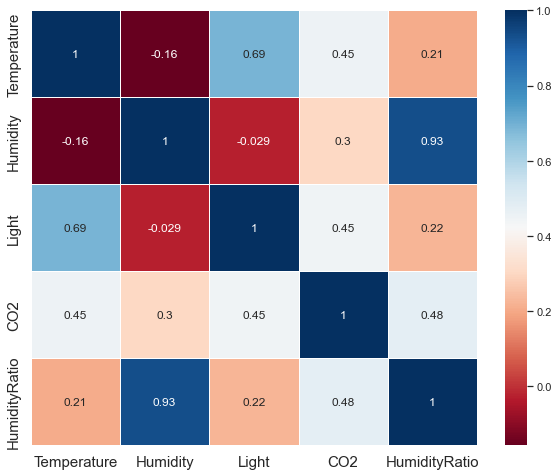

In [124]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df,num_cols)

   Occupancy  Ratio
0      15810 76.897
1       4750 23.103
##########################################


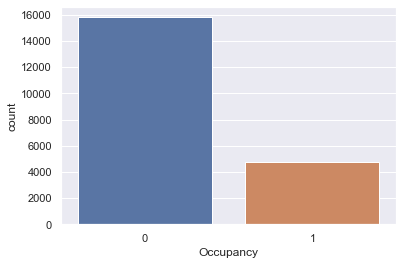

    Door  Ratio
0  10808 52.568
1   9752 47.432
##########################################


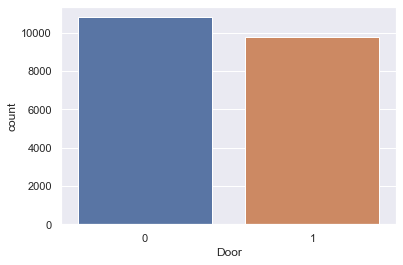

In [125]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count   20560.000
mean       20.906
std         1.055
min        19.000
5%         19.390
10%        19.650
20%        20.000
30%        20.290
40%        20.500
50%        20.700
60%        20.890
70%        21.290
80%        21.790
90%        22.315
95%        23.000
99%        23.945
max        24.408
Name: Temperature, dtype: float64


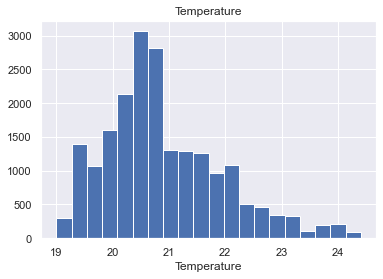

count   20560.000
mean       27.656
std         4.982
min        16.745
5%         19.050
10%        20.247
20%        23.445
30%        25.100
40%        26.290
50%        27.290
60%        28.918
70%        30.500
80%        32.290
90%        34.400
95%        35.790
99%        38.290
max        39.500
Name: Humidity, dtype: float64


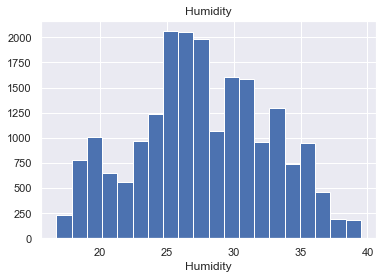

count   20560.000
mean      130.757
std       210.431
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%        75.825
80%       429.000
90%       459.000
95%       502.000
99%       744.000
max      1697.250
Name: Light, dtype: float64


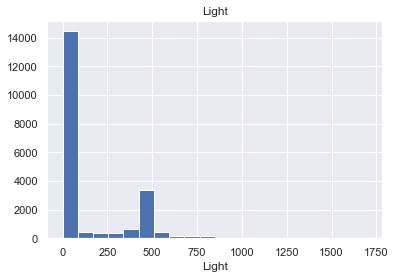

count   20560.000
mean      690.553
std       311.201
min       412.750
5%        433.500
10%       438.000
20%       450.000
30%       476.957
40%       514.500
50%       565.417
60%       633.500
70%       735.500
80%       882.600
90%      1152.000
95%      1419.762
99%      1719.427
max      2076.500
Name: CO2, dtype: float64


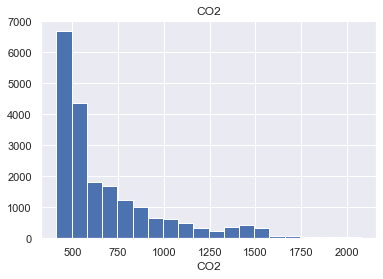

count   20560.000
mean        0.004
std         0.001
min         0.003
5%          0.003
10%         0.003
20%         0.004
30%         0.004
40%         0.004
50%         0.004
60%         0.004
70%         0.005
80%         0.005
90%         0.005
95%         0.005
99%         0.006
max         0.006
Name: HumidityRatio, dtype: float64


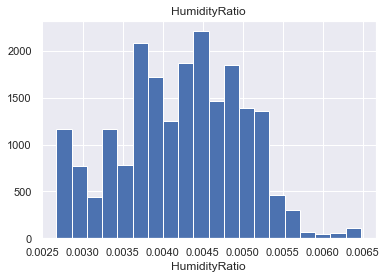

In [126]:
for col in num_cols:
    num_summary(df, col, plot=True)

##### Kategorik değişkenler ile hedef değişken incelemesini yapınız

In [128]:
for col in cat_cols:
    target_summary_with_cat(df, "Occupancy", col)

Occupancy
   TARGET_MEAN  Count  Ratio
0        0.000  15810 76.897
1        1.000   4750 23.103


Door
   TARGET_MEAN  Count  Ratio
0        0.250  10808 52.568
1        0.210   9752 47.432




##### Numerik değişkenlerin hedef değişkene göre analizi

In [129]:
for col in num_cols:
    target_summary_with_num(df, "Occupancy", col)

           Temperature
Occupancy             
0               20.585
1               21.976


           Humidity
Occupancy          
0            27.530
1            28.076


            Light
Occupancy        
0          25.238
1         481.967


              CO2
Occupancy        
0         604.997
1         975.322


           HumidityRatio
Occupancy               
0                  0.004
1                  0.005




### Data Preprocessing & Feature Engineering

In [130]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0


In [131]:
# dataframe oluştıracağım yeni date lerin nasıl etkileyeceğini görmek için önce kopyalanmış df de bakacağım.
dff = pd.concat([df1,df2,df3],axis=0,ignore_index=True)#axis=0  alt alta birleştirir
# DATE
# date i dönüştüreceğiz ama tabi  onu dönüştürelim
dff['date'] = pd.to_datetime(dff["date"], format="%Y-%m-%d")

# year : yıl değeri üretmek için
dff['year'] = dff['date'].dt.year 
# bakıldığında date year sadece 2015 o yüzden yıl değişkeniin veri setinde bir etkisi yok

# month = ay
dff['month'] = dff['date'].dt.month

# day name
dff['day_name'] = dff['date'].dt.day_name()

#saat
dff["day_hour"] = dff['date'].dt.hour

In [132]:
dff.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door,year,month,day_name,day_hour
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0,2015,2,Wednesday,17
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0,2015,2,Wednesday,17
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0,2015,2,Wednesday,17
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0,2015,2,Wednesday,17
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0,2015,2,Wednesday,17


In [133]:
dff.year.value_counts()

2015    20560
Name: year, dtype: int64

In [134]:
dff.month.value_counts()

2    20560
Name: month, dtype: int64

In [135]:
dff.day_name.value_counts()

Monday       3461
Tuesday      3454
Thursday     2880
Friday       2880
Saturday     2880
Sunday       2880
Wednesday    2125
Name: day_name, dtype: int64

In [136]:
dff.day_hour.value_counts()

19    915
22    915
1     915
4     915
7     915
21    900
0     900
3     900
18    900
6     900
5     885
8     885
20    885
23    885
2     885
16    854
15    840
17    835
9     834
10    776
14    761
13    732
12    720
11    708
Name: day_hour, dtype: int64

In [173]:
# hour
dff.loc[(dff["day_hour"] < 12), "new_hour"] = "morning"
dff.loc[(dff["day_hour"] >= 12), "new_hour"] = "noon"
dff.loc[(dff["day_hour"] >= 16 ), "new_hour"] = "afternoon"
dff.loc[(dff["day_hour"] >= 20), "new_hour"] = "evening"

In [174]:
dff.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door,year,month,day_name,day_hour,new_hour
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0,2015,2,Wednesday,17,afternoon
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0,2015,2,Wednesday,17,afternoon
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0,2015,2,Wednesday,17,afternoon
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0,2015,2,Wednesday,17,afternoon
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0,2015,2,Wednesday,17,afternoon


In [175]:
#Temperature
dff.loc[(dff["Temperature"] >= 19),"new_Temperature" ] = 19
dff.loc[(dff["Temperature"] >= 20),"new_Temperature" ] = 20
dff.loc[(dff["Temperature"] >= 21),"new_Temperature" ] = 21
dff.loc[(dff["Temperature"] >= 22),"new_Temperature" ] = 22
dff.loc[(dff["Temperature"] >= 23),"new_Temperature" ] = 23
dff.loc[(dff["Temperature"] >= 24),"new_Temperature" ] = 24

In [176]:
dff.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door,year,month,day_name,day_hour,new_hour,new_Temperature
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0,2015,2,Wednesday,17,afternoon,23.000
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0,2015,2,Wednesday,17,afternoon,23.000
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0,2015,2,Wednesday,17,afternoon,23.000
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0,2015,2,Wednesday,17,afternoon,23.000
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0,2015,2,Wednesday,17,afternoon,23.000


##### VERİ SETİNE EKLEYİM

In [137]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0


In [138]:
# DATE
df['date'] = pd.to_datetime(df["date"], format="%Y-%m-%d")
# day name
df['day_name'] = df['date'].dt.day_name()
#saat
df["day_hour"] = df['date'].dt.hour
# hour
df.loc[(df["day_hour"] < 12), "new_hour"] = "morning"
df.loc[(df["day_hour"] >= 12), "new_hour"] = "noon"
df.loc[(df["day_hour"] >= 16 ), "new_hour"] = "afternoon"
df.loc[(df["day_hour"] >= 20), "new_hour"] = "evening"

In [139]:
#Temperature
df.loc[(df["Temperature"] >= 19),"new_Temperature" ] = 19
df.loc[(df["Temperature"] >= 20),"new_Temperature" ] = 20
df.loc[(df["Temperature"] >= 21),"new_Temperature" ] = 21
df.loc[(df["Temperature"] >= 22),"new_Temperature" ] = 22
df.loc[(df["Temperature"] >= 23),"new_Temperature" ] = 23
df.loc[(df["Temperature"] >= 24),"new_Temperature" ] = 24

In [140]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Door,day_name,day_hour,new_hour,new_Temperature
0,2015-02-04 17:51:00,23.180,27.272,426.000,721.250,0.005,1,0,Wednesday,17,afternoon,23.000
1,2015-02-04 17:51:59,23.150,27.267,429.500,714.000,0.005,1,0,Wednesday,17,afternoon,23.000
2,2015-02-04 17:53:00,23.150,27.245,426.000,713.500,0.005,1,0,Wednesday,17,afternoon,23.000
3,2015-02-04 17:54:00,23.150,27.200,426.000,708.250,0.005,1,0,Wednesday,17,afternoon,23.000
4,2015-02-04 17:55:00,23.100,27.200,426.000,704.500,0.005,1,0,Wednesday,17,afternoon,23.000


In [141]:
df = df.drop(["date"], axis=1)
df = df.drop(["Temperature"], axis=1)

In [142]:
df.head()

,Humidity,Light,CO2,HumidityRatio,Occupancy,Door,day_name,day_hour,new_hour,new_Temperature
0,27.272,426.000,721.250,0.005,1,0,Wednesday,17,afternoon,23.000
1,27.267,429.500,714.000,0.005,1,0,Wednesday,17,afternoon,23.000
2,27.245,426.000,713.500,0.005,1,0,Wednesday,17,afternoon,23.000
3,27.200,426.000,708.250,0.005,1,0,Wednesday,17,afternoon,23.000
4,27.200,426.000,704.500,0.005,1,0,Wednesday,17,afternoon,23.000


In [143]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

In [144]:
df.head()

,HUMIDITY,LIGHT,CO2,HUMIDITYRATIO,OCCUPANCY,DOOR,DAY_NAME,DAY_HOUR,NEW_HOUR,NEW_TEMPERATURE
0,27.272,426.000,721.250,0.005,1,0,Wednesday,17,afternoon,23.000
1,27.267,429.500,714.000,0.005,1,0,Wednesday,17,afternoon,23.000
2,27.245,426.000,713.500,0.005,1,0,Wednesday,17,afternoon,23.000
3,27.200,426.000,708.250,0.005,1,0,Wednesday,17,afternoon,23.000
4,27.200,426.000,704.500,0.005,1,0,Wednesday,17,afternoon,23.000


In [39]:
check_df(df)

########################## Shape ###########################
Observations -------> 20560
Features     -------> 10
########################## Types ###########################
HUMIDITY           float64
LIGHT              float64
CO2                float64
HUMIDITYRATIO      float64
OCCUPANCY            int64
DOOR                 int64
DAY_NAME            object
DAY_HOUR             int64
NEW_HOUR            object
NEW_TEMPERATURE    float64
dtype: object
########################### İnfo ###########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HUMIDITY         20560 non-null  float64
 1   LIGHT            20560 non-null  float64
 2   CO2              20560 non-null  float64
 3   HUMIDITYRATIO    20560 non-null  float64
 4   OCCUPANCY        20560 non-null  int64  
 5   DOOR             20560 non-null  int64  
 6 

In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 20560
Variables: 10
cat_cols: 4
num_cols: 6
cat_but_car: 0
num_but_cat: 2


In [41]:
cat_cols

['DAY_NAME', 'NEW_HOUR', 'OCCUPANCY', 'DOOR']

In [42]:
num_cols

['HUMIDITY', 'LIGHT', 'CO2', 'HUMIDITYRATIO', 'DAY_HOUR', 'NEW_TEMPERATURE']

In [43]:
for col in cat_cols:
    cat_summary(df, col)

           DAY_NAME  Ratio
Monday         3461 16.834
Tuesday        3454 16.800
Thursday       2880 14.008
Friday         2880 14.008
Saturday       2880 14.008
Sunday         2880 14.008
Wednesday      2125 10.336
##########################################
           NEW_HOUR  Ratio
morning       10418 50.671
evening        3585 17.437
afternoon      3504 17.043
noon           3053 14.849
##########################################
   OCCUPANCY  Ratio
0      15810 76.897
1       4750 23.103
##########################################
    DOOR  Ratio
0  10808 52.568
1   9752 47.432
##########################################


In [44]:
for col in cat_cols:
    target_summary_with_cat(df, "OCCUPANCY", col)

DAY_NAME
           TARGET_MEAN  Count  Ratio
Friday           0.375   2880 14.008
Monday           0.372   3461 16.834
Saturday         0.000   2880 14.008
Sunday           0.000   2880 14.008
Thursday         0.272   2880 14.008
Tuesday          0.345   3454 16.800
Wednesday        0.192   2125 10.336


NEW_HOUR
           TARGET_MEAN  Count  Ratio
afternoon        0.355   3504 17.043
evening          0.000   3585 17.437
morning          0.180  10418 50.671
noon             0.536   3053 14.849


OCCUPANCY
   TARGET_MEAN  Count  Ratio
0        0.000  15810 76.897
1        1.000   4750 23.103


DOOR
   TARGET_MEAN  Count  Ratio
0        0.250  10808 52.568
1        0.210   9752 47.432




In [47]:
cat_cols = [col for col in cat_cols if "OCCUPANCY" not in col]

In [49]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [51]:
# Son güncel değişken türlerimi tutuyorum.
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OCCUPANCY" not in col]

Observations: 20560
Variables: 17
cat_cols: 11
num_cols: 6
cat_but_car: 0
num_but_cat: 11


In [52]:
cat_cols

['DAY_NAME_Monday',
 'DAY_NAME_Saturday',
 'DAY_NAME_Sunday',
 'DAY_NAME_Thursday',
 'DAY_NAME_Tuesday',
 'DAY_NAME_Wednesday',
 'NEW_HOUR_evening',
 'NEW_HOUR_morning',
 'NEW_HOUR_noon',
 'DOOR_1']

##### Aykırı gözlem analizi

In [53]:
# aykırı değer var mı yok mu 
for col in num_cols:
    print(col, check_outlier(df, col))

HUMIDITY False
LIGHT True
CO2 False
HUMIDITYRATIO False
DAY_HOUR False
NEW_TEMPERATURE False


In [54]:
# eşik değer ile doldur
replace_with_thresholds(df, "LIGHT")

In [55]:
for col in num_cols:
    print(col, check_outlier(df, col))

HUMIDITY False
LIGHT False
CO2 False
HUMIDITYRATIO False
DAY_HOUR False
NEW_TEMPERATURE False


#####  Eksik gözlem analizi

In [56]:
df.isnull().sum().sort_values(ascending=False)

HUMIDITY              0
DAY_NAME_Sunday       0
NEW_HOUR_noon         0
NEW_HOUR_morning      0
NEW_HOUR_evening      0
DAY_NAME_Wednesday    0
DAY_NAME_Tuesday      0
DAY_NAME_Thursday     0
DAY_NAME_Saturday     0
LIGHT                 0
DAY_NAME_Monday       0
NEW_TEMPERATURE       0
DAY_HOUR              0
OCCUPANCY             0
HUMIDITYRATIO         0
CO2                   0
DOOR_1                0
dtype: int64

In [57]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
# standartlaşmış değerileri colon isimleri ile df atıyorım
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [60]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

In [61]:
df.head()

,HUMIDITY,LIGHT,CO2,HUMIDITYRATIO,OCCUPANCY,DAY_HOUR,NEW_TEMPERATURE,DAY_NAME_MONDAY,DAY_NAME_SATURDAY,DAY_NAME_SUNDAY,DAY_NAME_THURSDAY,DAY_NAME_TUESDAY,DAY_NAME_WEDNESDAY,NEW_HOUR_EVENING,NEW_HOUR_MORNING,NEW_HOUR_NOON,DOOR_1
0,-0.077,1.406,0.099,0.735,1,0.785,2.370,0,0,0,0,0,1,0,0,0,0
1,-0.078,1.423,0.075,0.723,1,0.785,2.370,0,0,0,0,0,1,0,0,0,0
2,-0.082,1.406,0.074,0.718,1,0.785,2.370,0,0,0,0,0,1,0,0,0,0
3,-0.092,1.406,0.057,0.707,1,0.785,2.370,0,0,0,0,0,1,0,0,0,0
4,-0.092,1.406,0.045,0.689,1,0.785,2.370,0,0,0,0,0,1,0,0,0,0


In [62]:
y = df["OCCUPANCY"]
X = df.drop(["OCCUPANCY"], axis=1)

#### Base Model

In [148]:
base_models(X,y)

Base Models....
roc_auc: 0.9935 (LR) 
roc_auc: 0.9449 (KNN) 
roc_auc: 0.9885 (SVC) 
roc_auc: 0.8443 (CART) 
roc_auc: 0.9874 (RF) 
roc_auc: 0.994 (Adaboost) 
roc_auc: 0.9869 (GBM) 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


roc_auc: 0.9927 (XGBoost) 
roc_auc: 0.9907 (LightGBM) 


In [67]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.9828 (LR) 
accuracy: 0.9438 (KNN) 
accuracy: 0.9692 (SVC) 
accuracy: 0.9059 (CART) 
accuracy: 0.9726 (RF) 
accuracy: 0.9653 (Adaboost) 
accuracy: 0.9615 (GBM) 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


accuracy: 0.9698 (XGBoost) 
accuracy: 0.961 (LightGBM) 


In [68]:
base_models(X, y, scoring="f1")

Base Models....
f1: 0.9624 (LR) 
f1: 0.875 (KNN) 
f1: 0.9298 (SVC) 
f1: 0.7827 (CART) 
f1: 0.941 (RF) 
f1: 0.9224 (Adaboost) 
f1: 0.9147 (GBM) 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


f1: 0.9335 (XGBoost) 
f1: 0.9145 (LightGBM) 


##### Automated Hyperparameter Optimization

In [69]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

In [70]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [71]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [72]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.9449
roc_auc (After): 0.9836
KNN best params: {'n_neighbors': 37}

########## CART ##########
roc_auc (Before): 0.8415
roc_auc (After): 0.9901
CART best params: {'max_depth': 1, 'min_samples_split': 2}

########## RF ##########
roc_auc (Before): 0.9892
roc_auc (After): 0.9938
RF best params: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 300}

########## XGBoost ##########


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


roc_auc (Before): 0.9927


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

roc_auc (After): 0.9904
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.9907
roc_auc (After): 0.9939
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



In [80]:
rf_model = LGBMClassifier(random_state=17)

In [83]:
rf_final = rf_model.set_params(learning_rate= 0.01, n_estimators= 300,  random_state=17).fit(X, y)

In [84]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.9672665369649807

In [85]:
cv_results['test_f1'].mean()

0.9337145375819154

In [86]:
cv_results['test_roc_auc'].mean()

0.9922029361829621

##### Prediction for a New Observation

In [87]:
X.columns

Index(['HUMIDITY', 'LIGHT', 'CO2', 'HUMIDITYRATIO', 'DAY_HOUR', 'NEW_TEMPERATURE', 'DAY_NAME_MONDAY', 'DAY_NAME_SATURDAY', 'DAY_NAME_SUNDAY', 'DAY_NAME_THURSDAY',
       'DAY_NAME_TUESDAY', 'DAY_NAME_WEDNESDAY', 'NEW_HOUR_EVENING', 'NEW_HOUR_MORNING', 'NEW_HOUR_NOON', 'DOOR_1'],
      dtype='object')

In [88]:
random_user = X.sample(1, random_state=45)

In [89]:
random_user

,HUMIDITY,LIGHT,CO2,HUMIDITYRATIO,DAY_HOUR,NEW_TEMPERATURE,DAY_NAME_MONDAY,DAY_NAME_SATURDAY,DAY_NAME_SUNDAY,DAY_NAME_THURSDAY,DAY_NAME_TUESDAY,DAY_NAME_WEDNESDAY,NEW_HOUR_EVENING,NEW_HOUR_MORNING,NEW_HOUR_NOON,DOOR_1
10262,-0.533,-0.622,-0.557,-0.569,-1.476,-0.409,0,0,0,0,0,1,0,1,0,0


In [90]:
rf_final.predict(random_user)

array([0], dtype=int64)

In [93]:
from sklearn.metrics import confusion_matrix
y_pred =rf_final.predict(X)
print(confusion_matrix(y, y_pred))

[[15728    82]
 [   25  4725]]


###### Feature Importance

In [95]:
# yeni eklenenler etkiler.
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

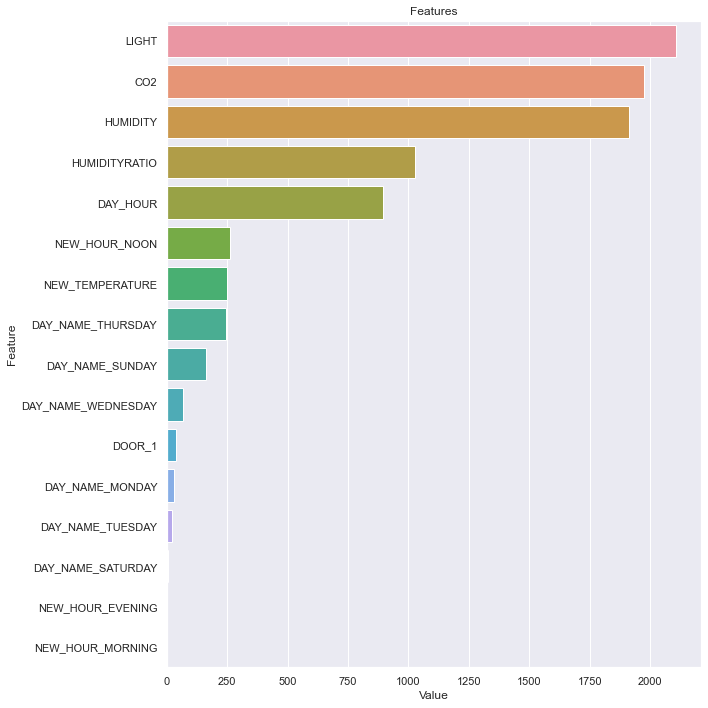

In [96]:
plot_importance(rf_final, X)